# RIXS calculations for an atomic model
Here we show how to compute RIXS for Sr₂YIrO₆ based on Ref. [^1]. 

![Sr₂YIrO₆](./Sr2YIrO6.png)

## Imports

In [1]:
import edrixs
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

/home/runner/work/RIXSREXS2025-tutorial/RIXSREXS2025-tutorial/.pixi/envs/default/lib/python3.13/site-packages/edrixs/utils.py:10: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
# Secretly make figures look nice!
plt.rcParams.update({'figure.dpi': 150, 'savefig.dpi': 150,
                     'font.size': 8})

# fix a threading problem on mybinder.org
try:
    from threadpoolctl import threadpool_limits
    _tpool_ctx = threadpool_limits(limits=1)
except:
    pass

## Specify active core and valence orbitals

In [3]:
shell_name = ('t2g', 'p32')
v_noccu = 4

## Slater parameters
The paper specifies the valence Coulomb interactions and spin orbit coupling [^1][^2]. Other interaction parameters can be loaded from a database containing Hartree-Fock predictions.

In [4]:
F2_dd = 2.15
F4_dd = 1.34
lam = 0.42

info = edrixs.utils.get_atom_data('Ir', '5d', v_noccu, edge='L3')
G1_dp = info['slater_n'][5][1]
G3_dp = info['slater_n'][6][1]
F2_dp = info['slater_n'][4][1]

slater = [[0, F2_dd, F4_dd],
          [0, F2_dd, F4_dd, 0, F2_dp, G1_dp, G3_dp]]
v_soc = (lam, lam)

## Diagonalization
Since we have already specified a $t_{2g}$ subshell only, we do not need to pass an additional `v_cfmat` matrix.

Note that we need to tune the energy of the intermediate state via `off`.

In [5]:
off = 11216
out = edrixs.ed_1v1c_py(shell_name, shell_level=(0, -off), v_soc=v_soc,
                        c_soc=info['c_soc'], v_noccu=v_noccu, slater=slater)
eval_i, eval_n, trans_op = out

edrixs >>> Running ED ...

    Summary of Slater integrals:
    ------------------------------
    Terms,   Initial Hamiltonian,  Intermediate Hamiltonian
     F0_vv :          0.0000000000        0.0000000000
     F2_vv :          2.1500000000        2.1500000000
     F4_vv :          1.3400000000        1.3400000000
     F0_vc :          0.0000000000        0.0000000000
     F2_vc :          0.0000000000        1.0700000000
     G1_vc :          0.0000000000        0.9570000000
     G3_vc :          0.0000000000        0.5690000000
     F0_cc :          0.0000000000        0.0000000000
     F2_cc :          0.0000000000        0.0000000000
edrixs >>> Dimension of the initial Hamiltonian:  15
edrixs >>> Dimension of the intermediate Hamiltonian:  24
edrixs >>> Building Many-body Hamiltonians ...
edrixs >>> Done !
edrixs >>> Exact Diagonalization of Hamiltonians ...
edrixs >>> Done !
edrixs >>> ED Done !


edrixs >>> Dimension of the initial Hamiltonian:  15
edrixs >>> Dimension of the intermediate Hamiltonian:  24
edrixs >>> Building Many-body Hamiltonians ...
edrixs >>> Done !
edrixs >>> Exact Diagonalization of Hamiltonians ...
edrixs >>> Done !
edrixs >>> ED Done !


## Compute XAS

In [6]:
ominc = np.arange(11200, 11230, 0.1)
temperature = 300  # in K

thin = np.deg2rad(30)
pol_type = [('linear', 0)]

xas = edrixs.xas_1v1c_py(
    eval_i, eval_n, trans_op, ominc, gamma_c=info['gamma_c'],
    thin=thin, pol_type=pol_type)

edrixs >>> Running XAS ...
edrixs >>> XAS Done !


The array ``xas`` will have shape ``(len(ominc), len(pol_type))``.

## Compute RIXS

In [7]:
eloss = np.linspace(-.5, 6, 400)
pol_type_rixs = [('linear', 0, 'linear', 0), ('linear', 0, 'linear', np.pi/2)]
gs_list = [0, 1, 2]
thout = np.deg2rad(60)
gamma_f = 0.02

rixs = edrixs.rixs_1v1c_py(
    eval_i, eval_n, trans_op, ominc, eloss,
    gamma_c=info['gamma_c'], gamma_f=gamma_f,
    thin=thin, thout=thout,
    pol_type=pol_type_rixs, gs_list=gs_list,
    temperature=temperature
)

edrixs >>> Running RIXS ...
edrixs >>> RIXS Done !


edrixs >>> RIXS Done !


The array ``rixs`` will have shape ``(len(ominc), len(eloss), len(pol_type))``.

## Plot XAS and RIXS
What do you expect the XAS spectrum to look like?

Why is there zero elastic intensity and what could I alter in the experimental geometry in order to see elastic intensity?

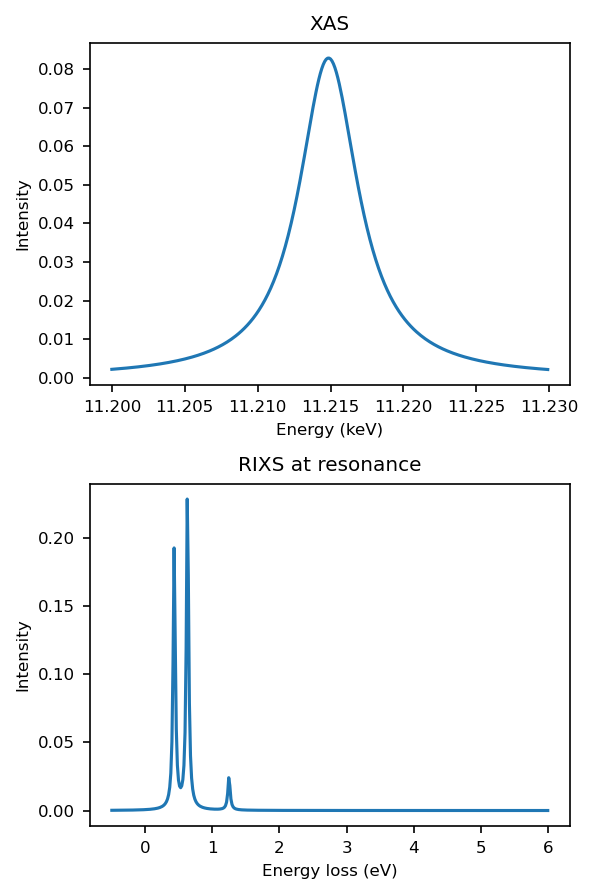

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(4, 6))

def plot_it(axs, ominc, xas, eloss, rixscut, rixsmap=None, label=None):
    axs[0].plot(ominc/1000, xas[:, 0], label=label)
    axs[0].set_xlabel('Energy (keV)')
    axs[0].set_ylabel('Intensity')
    axs[0].set_title('XAS')

    axs[1].plot(eloss, rixscut, label=f"{label}")
    axs[1].set_xlabel('Energy loss (eV)')
    axs[1].set_ylabel('Intensity')
    axs[1].set_title(f'RIXS at resonance')

rixs_pol_sum = rixs.sum(-1)
cut_index = np.argmax(rixs_pol_sum[:, eloss < 2].sum(1))
rixscut = rixs_pol_sum[cut_index]

plot_it(axs.ravel(), ominc, xas, eloss, rixscut, rixsmap=rixs_pol_sum)
plt.tight_layout()

## Full d shell calculation
Does it make sense to consider only the $t_{2g}$ subshell [^3]?

How will the XAS and RIXS spectra change when including the $e_{g}$ states?

In [9]:
ten_dq = 3.5
v_cfmat = edrixs.cf_cubic_d(ten_dq)


out = edrixs.ed_1v1c_py(('d', 'p32'), shell_level=(0, -off), v_soc=v_soc,
                        v_cfmat=v_cfmat,
                        c_soc=info['c_soc'], v_noccu=v_noccu, slater=slater)
eval_i, eval_n, trans_op = out

edrixs >>> Running ED ...

    Summary of Slater integrals:
    ------------------------------
    Terms,   Initial Hamiltonian,  Intermediate Hamiltonian
     F0_vv :          0.0000000000        0.0000000000
     F2_vv :          2.1500000000        2.1500000000
     F4_vv :          1.3400000000        1.3400000000
     F0_vc :          0.0000000000        0.0000000000
     F2_vc :          0.0000000000        1.0700000000
     G1_vc :          0.0000000000        0.9570000000
     G3_vc :          0.0000000000        0.5690000000
     F0_cc :          0.0000000000        0.0000000000
     F2_cc :          0.0000000000        0.0000000000

edrixs >>> Dimension of the initial Hamiltonian:  210
edrixs >>> Dimension of the intermediate Hamiltonian:  1008
edrixs >>> Building Many-body Hamiltonians ...
edrixs >>> Done !
edrixs >>> Exact Diagonalization of Hamiltonians ...
edrixs >>> Done !
edrixs >>> ED Done !


edrixs >>> Done !
edrixs >>> Exact Diagonalization of Hamiltonians ...


edrixs >>> Done !
edrixs >>> ED Done !


In [10]:
xas_full_d_shell = edrixs.xas_1v1c_py(
    eval_i, eval_n, trans_op, ominc, gamma_c=info['gamma_c'],
    thin=thin, pol_type=pol_type,
    gs_list=gs_list)

edrixs >>> Running XAS ...
edrixs >>> XAS Done !


In [11]:
rixs_full_d_shell = edrixs.rixs_1v1c_py(
    eval_i, eval_n, trans_op, np.array([11215]), eloss,
    gamma_c=info['gamma_c'], gamma_f=gamma_f,
    thin=thin, thout=thout,
    pol_type=pol_type_rixs,
    temperature=temperature)

edrixs >>> Running RIXS ... 
edrixs >>> RIXS Done !


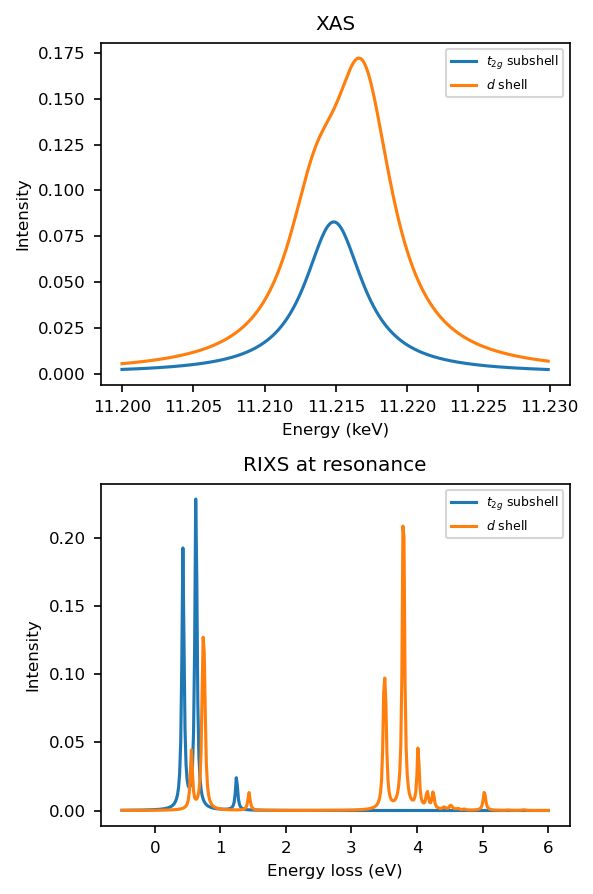

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(4, 6))

plot_it(axs, ominc, xas, eloss, rixscut, label='$t_{2g}$ subshell')
rixscut_d_shell = rixs_full_d_shell.sum((0, -1))
plot_it(axs, ominc, xas_full_d_shell, eloss, rixscut_d_shell, label='$d$ shell')

for ax in axs:
    ax.legend(fontsize=6)
plt.tight_layout()

## References

[^1]: Bo Yuan et al.,
       [Phys. Rev. B 95, 235114 (2017)](https://doi.org/10.1103/PhysRevB.95.235114)
[^2]: EDRIXS provides utilities for converting $U$ and $J_H$ into Slater parameters [here](https://edrixs.github.io/edrixs/reference/utils.html#edrixs.utils.UdJH_to_F0F2F4).
[^3]: Georgios L. Stamokostas and Gregory A. Fiete [Phys. Rev. B 97, 085150 (2018)](https://doi.org/10.1103/PhysRevB.97.085150)